In [1]:
from __future__ import absolute_import
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--name "rec_cuenta" --master yarn --conf spark.executor.memory=3G --conf spark.executor.cores=1 --conf spark.executor.instances=32 pyspark-shell' 


import sys
#!{sys.executable} -m pip install gcsfs
#!{sys.executable} -m pip install pyspark_dist_explore
#!{sys.executable} -m pip install findspark
#!{sys.executable} -m pip install jupyter

In [9]:
#import pyspark
#from pyspark.context import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.session import SparkSession
from pyspark.sql import Row
#from pyspark.conf import SparkConf 
from pyspark import SparkConf, SparkContext
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.sql.functions import explode, col, collect_set, udf
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType, StructType, StructField, DoubleType
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from datetime import datetime
from pyspark.mllib.evaluation import MulticlassMetrics, RankingMetrics, BinaryClassificationMetrics

In [3]:
#from pyspark.sql import SparkSession


sc.getConf().toDebugString()

'spark.app.id=application_1551903967241_0162\nspark.app.name=pyspark-shell\nspark.driver.appUIAddress=http://dprc-mkt-tensorflow-tony-jupyter-m.c.sistemas-bi.internal:4043\nspark.driver.extraJavaOptions=-Dflogger.backend_factory=com.google.cloud.hadoop.repackaged.gcs.com.google.common.flogger.backend.log4j.Log4jBackendFactory#getInstance\nspark.driver.host=dprc-mkt-tensorflow-tony-jupyter-m.c.sistemas-bi.internal\nspark.driver.maxResultSize=1920m\nspark.driver.memory=3840m\nspark.driver.port=36761\nspark.dynamicAllocation.enabled=true\nspark.dynamicAllocation.maxExecutors=10000\nspark.dynamicAllocation.minExecutors=1\nspark.eventLog.dir=hdfs://dprc-mkt-tensorflow-tony-jupyter-m/user/spark/eventlog\nspark.eventLog.enabled=true\nspark.executor.cores=1\nspark.executor.extraJavaOptions=-Dflogger.backend_factory=com.google.cloud.hadoop.repackaged.gcs.com.google.common.flogger.backend.log4j.Log4jBackendFactory#getInstance\nspark.executor.id=driver\nspark.executor.instances=32\nspark.executor

## parametros para validación cruzada

In [6]:
alpha_list =[30.0,  50.0, 70.0]
rank_list =[20, 100, 200]
maxIter_list =[4]
regParam_list =[0.1, 1,50,100,400]
k_folds=5
n_items=50
training_split=0.8
validation_split=0.2

#alpha_list =[1.0]
#rank_list =[4,10]
#maxIter_list =[4]
#regParam_list =[0.9]
#k_folds=2
#n_items=5

## Creación de rutas para leer data, guardar diccionarios y guardar ouputs

In [7]:
# reading from bucket
bucket = sc._jsc.hadoopConfiguration().get('fs.gs.system.bucket')
print(bucket)
todays_date = '2019_02_18_13_39_11' #'2019_02_15_19_01_20'
bucket_name = "datasets_prueba"
datafr_name = "local"
bucket_path = "gs://{}/{}/{}/{}".format(bucket, bucket_name, datafr_name, todays_date)
print(bucket_path)


bucket = sc._jsc.hadoopConfiguration().get('fs.gs.system.bucket')
bucket_name_subfolder = "research"
datafr_name = "codigo_cuenta_rec"
training_folder_name="training_binario_TF_IDF"
testing_folder_name="testing_binario_TF_IDF"
eval_folder_name="eval_binario_TF_IDF"

path_rating_training_TF_IDF_binario = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,training_folder_name)
path_rating_testing_TF_IDF_binario = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,testing_folder_name)
path_rating_eval_TF_IDF_binario = "gs://{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, datafr_name,eval_folder_name)

print(path_rating_training_TF_IDF_binario)
print(path_rating_testing_TF_IDF_binario)
print(path_rating_eval_TF_IDF_binario)

pry_spsa
gs://pry_spsa/datasets_prueba/local/2019_02_18_13_39_11
gs://pry_spsa/research/codigo_cuenta_rec/training_binario_TF_IDF/
gs://pry_spsa/research/codigo_cuenta_rec/testing_binario_TF_IDF/
gs://pry_spsa/research/codigo_cuenta_rec/eval_binario_TF_IDF/


In [10]:
# ruta para guardar el pipeline y la grilla
file_name = "scripts"
type_file = "recomendacion"
typo_recomendacion= "codigo_cuenta"
typo_output= "grilla_CV_tf_idf_binario"
path_binary_pipeline_cv_codigo_cuenta = "gs://{}/{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, file_name, type_file, typo_recomendacion)
#path_binary_pipeline_cv_codigo_cuenta
path_binary_pipeline_cv_codigo_cuenta_grilla = "gs://{}/{}/{}/{}/{}/{}/".format(bucket, bucket_name_subfolder, file_name, type_file, typo_recomendacion, typo_output)
print(path_binary_pipeline_cv_codigo_cuenta_grilla)


gs://pry_spsa/research/scripts/recomendacion/codigo_cuenta/grilla_CV_tf_idf_binario/


## creación de pipeline con Cross Validation

In [8]:
## Leemos los datos que previamente fueron preparados


# salvamos traing_df y testing_df para usarlos en el precisión y recall



ratings_train_tf_idf_binary=spark.read.parquet(path_rating_training_TF_IDF_binario)
ratings_test_tf_idf_binary=spark.read.parquet(path_rating_testing_TF_IDF_binario)
ratings_eval_tf_idf_binary=spark.read.parquet(path_rating_eval_TF_IDF_binario)



ratings_df= ratings_train_tf_idf_binary.union(ratings_test_tf_idf_binary.union(ratings_eval_tf_idf_binary))


#Building train and validation test sets
ratings_train, ratings_test = ratings_df.randomSplit([training_split, validation_split], seed = 0)

ratings_df.show(3)


#ratings_train.schema
ratings_test.show()

AnalysisException: 'Path does not exist: gs://pry_spsa/research/codigo_cuenta_rec/training_binario_TF_IDF;'

In [7]:

#    rank = la cantidad de factores latentes en el modelo (4,  50 , 100, 150, 200 como valores seleccionados)
#    maxIter = el número máximo de iteraciones (valor predeterminado)
#    regParam = el parámetro de regularización (0.1, 0.05 y 0.01 como valores seleccionados)
#    alpha: Refleja cuanto valoramos los eventos observados versus los no observados
#    https://amsterdam.luminis.eu/2016/12/04/alternating-least-squares-implicit-feedback-search-alpha/
#    iteration
#ratings_train2 = ratings_train.withColumnRenamed("rating", "label")


initial_date = datetime.strftime(datetime.today(), "%Y_%m_%d_%H_%M_%S")
print(initial_date)

feature_columns = ratings_train.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

als_implicit = ALS(userCol="userId", itemCol="itemId", ratingCol="rating", coldStartStrategy="drop", implicitPrefs=True, seed=625)

pipeline = Pipeline(stages=[assembler, als_implicit])
# Diseña la grilla de parametros a probar

#paramGrid= ParamGridBuilder().addGrid(als_implicit.rank, [40]).build()



paramGrid = ParamGridBuilder()\
            .addGrid(als_continuo.rank, rank_list)\
            .addGrid(als_continuo.regParam, regParam_list)\
            .addGrid(als_continuo.alpha, alpha_list)\
            .addGrid(als_continuo.maxIter, maxIter_list)\
            .build()
           
            
           ##.addGrid(als_implicit.rank, [50]).build()
# Set evaluator
## usamos el evaluador ninario que se encuentra en la librería pyspar.ml.evaluation
# http://spark.apache.org/docs/2.4.0/api/python/_modules/pyspark/ml/evaluation.html

#modelEvaluator = RegressionEvaluator(predictionCol="features", labelCol="rating", metricName="rmse")
modelEvaluator = BinaryClassificationEvaluator( rawPredictionCol='features', labelCol="rating", metricName="areaUnderPR")

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=modelEvaluator,
                          numFolds=3)



# Perform cross-validation


cvModel = crossval.fit(ratings_train)

# Select best model and get its parameters
best_als_model = cvModel.bestModel.stages[1]

#best_als_model = cvModel
print("Best number of latent factors (rank parameter): " + str(best_als_model._java_obj.parent().getRank()))
print("Best value of regularization factor: " + str(best_als_model._java_obj.parent().getRegParam()))
print("Max Iterations: " + str(best_als_model._java_obj.parent().getMaxIter()))
print("Best value of alpha: " + str(best_als_model._java_obj.parent().getAlpha()))

final_date = datetime.strftime(datetime.today(), "%Y_%m_%d_%H_%M_%S")
print(final_date)

#https://medium.com/datos-y-ciencia/intro-al s-pyspark-7de7f3ba3b0a

2019_03_26_21_24_19
Best number of latent factors (rank parameter): 100
Best value of regularization factor: 0.9
Max Iterations: 10
Best value of alpha: 50.0
2019_03_27_00_28_12


In [8]:
## entrenamiento del modelo con los mejores parametros
#best_als_model.save("gs://pry_spsa/models/my_best_als_model")
#best_als_model.write().overwrite().save("gs://pry_spsa/models/my_best_als_model2_tf_idf_binary") 
#cvModel.save("gs://pry_spsa/models/cvModel_als_model")
#pipeline.write().overwrite().save("gs://pry_spsa/models/pipeline_als_model2_tf_idf_binary")

# salvamos y cargamos la validación crizada

#cvModel.bestModel.write().overwrite().save(path_binary_pipeline_cv_codigo_cuenta)

In [9]:
#cvModel.save("gs://pry_spsa/models/cross_val_als_model2")
#https://stackoverflow.com/questions/36446629/loading-a-trained-crossvalidation-model-in-spark
#https://stackoverflow.com/questions/49916196/attributeerror-pipeline-object-has-no-attribute-transfer-param-map-to-java
#cvModel.bestModel.write().overwrite().save("gs://pry_spsa/models/cross_val_als_model2")
#type(cvModel.bestModel.extractParamMap)
#best_als_model_prueba = CrossValidatorModel.load("gs://pry_spsa/models/cross_val_als_model2")

#type(best_als_model_prueba)


## Descargamos la grilla de resultados que se tunearon

In [10]:
# salavamos el paramteros

params = [{p.name: v for p, v in m.items()} for m in cvModel.getEstimatorParamMaps()]
parameter_df=pd.DataFrame.from_dict([
    {cvModel.getEvaluator().getMetricName(): metric, **ps} 
    for ps, metric in zip(params, cvModel.avgMetrics)
])

#guardamos resultados de la grilla
parameter_df_spark= spark.createDataFrame(parameter_df)
parameter_df_spark.coalesce(1).write.mode("overwrite").format('csv').save(path_binary_pipeline_cv_codigo_cuenta_grilla,header = 'true')
parameter_df_spark.show()

+-----+------------------+-------+----+--------+
|alpha|       areaUnderPR|maxIter|rank|regParam|
+-----+------------------+-------+----+--------+
|  1.0|0.9223161764496306|     10|   4|     0.9|
| 50.0|0.9223161764496306|     10|   4|     0.9|
|100.0|0.9223161764496304|     10|   4|     0.9|
|  1.0|0.9223161764496304|     10|   4|     0.5|
| 50.0|0.9223161764496306|     10|   4|     0.5|
|100.0|0.9223161764496306|     10|   4|     0.5|
|  1.0|0.9223161764496304|     10|   4|    0.01|
| 50.0|0.9223161764496306|     10|   4|    0.01|
|100.0|0.9223161764496307|     10|   4|    0.01|
|  1.0|0.9223161764496306|     10| 100|     0.9|
| 50.0|0.9223161764496308|     10| 100|     0.9|
|100.0|0.9223161764496307|     10| 100|     0.9|
|  1.0|0.9223161764496304|     10| 100|     0.5|
| 50.0|0.9223161764496308|     10| 100|     0.5|
|100.0|0.9223161764496306|     10| 100|     0.5|
|  1.0|0.9223161764496305|     10| 100|    0.01|
| 50.0|0.9223161764496307|     10| 100|    0.01|
|100.0|0.92231617644

## Calculo del precisión y el Recall para una recomendación en training 

In [11]:

#https://stackoverflow.com/questions/37462689/evaluation-metrics-for-binary-classification-in-spark-auc-and-pr-curve
#https://surprise.readthedocs.io/en/latest/FAQ.html#how-to-compute-precision-k-and-recall-k

#

# Evaluate the model on training data

predictions_train = best_als_model.transform(ratings_train)

predictions_train = predictions_train.withColumn("label", predictions_train.rating.cast(DoubleType()).alias('label'))
predictions_train = predictions_train.withColumn("prediction", predictions_train.prediction.cast(DoubleType()))
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")#.MetricName('precision')
  
precision_n_train = evaluator_precision.evaluate(predictions_train , {evaluator_precision.metricName: "weightedPrecision"})
recall_n_train = evaluator_precision.evaluate(predictions_train , {evaluator_precision.metricName: "weightedRecall"})
f1_score_n_train = evaluator_precision.evaluate(predictions_train , {evaluator_precision.metricName: "f1"})


print(precision_n_train)
print(recall_n_train)
print(f1_score_n_train)


1.0
0.179646866458062
0.1796469066011022


In [12]:
predictions_train.show()

# Lo que hay en la columna predicition es la probabilidad con la que se recomienda cada producto

+------+------+------+-------------------+-----+
|userId|itemId|rating|         prediction|label|
+------+------+------+-------------------+-----+
|168349|   148|     1| 0.5671214461326599|  1.0|
|189242|   148|     1|0.44841471314430237|  1.0|
|429144|   148|     1| 0.3919920325279236|  1.0|
|454003|   148|     1|0.42298221588134766|  1.0|
|127844|   148|     1|0.41384729743003845|  1.0|
|140811|   148|     1|0.24730142951011658|  1.0|
|240056|   148|     1|  0.620064377784729|  1.0|
| 94933|   148|     1| 0.5360722541809082|  1.0|
|194496|   148|     1| 0.6648216247558594|  1.0|
| 41601|   148|     1|0.32854798436164856|  1.0|
| 59068|   148|     1|0.48471763730049133|  1.0|
|172117|   148|     1| 0.6772307753562927|  1.0|
|312865|   148|     1| 0.2829402685165405|  1.0|
|433029|   148|     1|0.46824440360069275|  1.0|
| 43252|   148|     1| 0.7820416688919067|  1.0|
| 69839|   148|     1|0.43294695019721985|  1.0|
| 72367|   148|     1|0.40196681022644043|  1.0|
|223605|   148|     

In [13]:

#https://stackoverflow.com/questions/37462689/evaluation-metrics-for-binary-classification-in-spark-auc-and-pr-curve
#https://surprise.readthedocs.io/en/latest/FAQ.html#how-to-compute-precision-k-and-recall-k

# evaluación sobre datos de Testing
predictions_test = best_als_model.transform(ratings_test)

predictions_test = predictions_test.withColumn("rating", predictions_test.rating.cast(DoubleType()))
predictions_test = predictions_test.withColumn("prediction", predictions_test.prediction.cast(DoubleType()))
evaluator_precision = MulticlassClassificationEvaluator(labelCol="rating", predictionCol="prediction")#.MetricName('precision')
  
precision_n_test = evaluator_precision.evaluate(predictions_test , {evaluator_precision.metricName: "weightedPrecision"})
recall_n_test = evaluator_precision.evaluate(predictions_test , {evaluator_precision.metricName: "weightedRecall"})
f1_score_n_test = evaluator_precision.evaluate(predictions_test , {evaluator_precision.metricName: "f1"})


print(precision_n_test)
print(recall_n_test)
print(f1_score_n_test)


0.17992154478940076
0.17998289861694733
0.17995221647360235


## Gráfica  de precisión a n articulos para training y Testing

In [19]:
n_items=50
# Creamos las recomendaciones en training

users_train = ratings_train.select(als_implicit.getUserCol())
recomendaciones_train = best_als_model.recommendForUserSubset(users_train,n_items)
recomendaciones_train.createOrReplaceTempView("recomendaciones_training")
recomendaciones_train_df=spark.sql('select distinct userId, recommendations.itemId prediction from recomendaciones_training')
recomendaciones_train_df.createOrReplaceTempView("recomendaciones_train_df")
#recomendaciones_train_df.cache()
#recomendaciones_train_df.show()

# Creamos las recomendaciones en testing

users_test = ratings_test.select(als_implicit.getUserCol())
recomendaciones_testing = best_als_model.recommendForUserSubset(users_test,n_items)
recomendaciones_testing.createOrReplaceTempView("recomendaciones_testing")
recomendaciones_testing_df=spark.sql('select distinct userId, recommendations.itemId prediction from recomendaciones_testing')
recomendaciones_testing_df.createOrReplaceTempView("recomendaciones_testing_df")
#recomendaciones_testing_df.cache()
recomendaciones_testing_df.show()

+------+--------------------+
|userId|          prediction|
+------+--------------------+
|139969|[5116, 155, 4756,...|
|201683|[3675, 14931, 194...|
|204356|[2125, 6704, 6038...|
|224487|[2208, 8860, 3630...|
|253924|[19034, 8886, 886...|
|267948|[7744, 1816, 7745...|
|278952|[7744, 7745, 1128...|
|380651|[6928, 8395, 8394...|
|420617|[927, 1198, 10045...|
|445313|[583, 12779, 147,...|
|113924|[61, 5127, 339, 1...|
|179799|[8283, 7148, 8279...|
|282698|[9531, 5481, 5583...|
| 31681|[4520, 4462, 4099...|
| 52172|[5855, 4887, 4947...|
| 87931|[2899, 4827, 1095...|
|223446|[14877, 18752, 11...|
|363478|[2447, 206, 17450...|
|455442|[7596, 2771, 3230...|
|466024|[2365, 249, 473, ...|
+------+--------------------+
only showing top 20 rows



In [20]:
#Creamos el dataframe de prediction y label para training y testing
# La idea es poder crear dos columnas donde aparecen los productos recomendados y los comprados para cada cuenta
#training

train_comprados=ratings_train.groupby("userId").agg(collect_set("itemId").alias('label'))
train_comprados.createOrReplaceTempView("train_comprados")

test_comprados=ratings_test.groupby("userId").agg(collect_set("itemId").alias('label'))
test_comprados.createOrReplaceTempView("test_comprados")

query_join_nested_list_train='''select b.prediction, a.label
                          from train_comprados a join recomendaciones_train_df b on a.userId=b.userId
'''
query_join_nested_list_test='''select b.prediction, a.label
                          from test_comprados a join recomendaciones_testing_df b on a.userId=b.userId
'''

# Aqui tengo el dataframe de artículos ocmprados y recomendados tanto en entrenamiento como en testeo

predictionAndLabels_train=spark.sql(query_join_nested_list_train)
predictionAndLabels_test=spark.sql(query_join_nested_list_test)
predictionAndLabels_test.show(5)



+--------------------+--------------------+
|          prediction|               label|
+--------------------+--------------------+
|[19454, 3519, 283...|[13009, 7943, 264...|
|[15506, 48, 2132,...|[2730, 712, 808, ...|
|[719, 1648, 48, 1...|[560, 844, 12938,...|
|[2657, 6888, 1875...|[8233, 5812, 4953...|
|[4169, 7464, 4188...|[3413, 2274, 7868...|
+--------------------+--------------------+
only showing top 5 rows



In [21]:
# Instantiate metrics object

metrics_ranking_train = RankingMetrics(predictionAndLabels_train.rdd)
metrics_ranking_test = RankingMetrics(predictionAndLabels_test.rdd)



In [22]:
# Creamos Dataframe de preciiones en trainin y testeo



## Creación de lista con el número de recomendaciones a ejecutar
fibonacci=[1,2,3,5,8,13,21,25,30,34,40,45,55,89,144,233,377,610,987]
cantidad_recomendaciones= [i for i in fibonacci if i < n_items] +[n_items]

rdd = sc.parallelize(cantidad_recomendaciones)

predicciones=list()

for n in cantidad_recomendaciones:
    predicciones.append((n,metrics_ranking_train.precisionAt(n),metrics_ranking_test.precisionAt(n) ))

predicciones_n=pd.DataFrame(predicciones, columns=['cantidad_rec','precision_train','precision_test'])
predicciones_n=predicciones_n.dropna()
predicciones_n

cantidad_rec  precision_train  precision_test
0              1         0.397792        0.039704
1              2         0.373510        0.038313
2              3         0.353048        0.037307
3              5         0.324025        0.035594
4              8         0.296210        0.033541
5             13         0.266969        0.031273
6             21         0.237236        0.028725
7             25         0.226433        0.027824
8             30         0.215078        0.026837
9             34         0.207350        0.026138
10            40         0.197362        0.025227
11            45         0.190097        0.024543
12            50         0.183612        0.023923

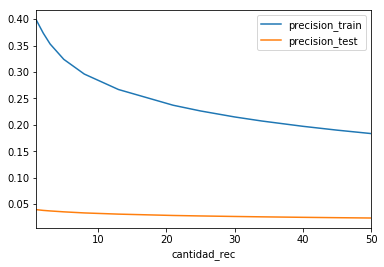

In [23]:
predicciones_n.plot(x='cantidad_rec', y=['precision_train','precision_test'])

In [ ]:
def recall_k(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

In [ ]:
#metrics_pre.confusionMatrix()
predictionAndLabels_.schema

## Salvando el modelo en el bucket

In [ ]:
# Save and load model

#model.write().overwrite().save("gs://pry_spsa/models/my_als_model")
model.save("gs://pry_spsa/models/my_als_model")
#sameModel = MatrixFactorizationModel.load(sc, "gs://pry_spsa/models/my_als_model")

## Loading the saved model

In [ ]:
# Generate top 10 movie recommendations for a specified set of users
#users_148 = ratings_train.select(als.getUserCol()).distinct().limit(3)
#userSubsetRecs = model.recommendForUserSubset(users, 10)
# Generate top 10 user recommendations for a specified set of items
#items = ratings_train.select(als.getItemCol()).distinct().limit(3)
#itemsSubSetRecs = model.recommendForItemSubset(items, 10)
# TF_IDF para sistemas de recomendación
#https://towardsdatascience.com/recommender-engine-under-the-hood-7869d5eab072  

#userSubsetRecs

In [ ]:

#https://medium.com/google-cloud/recommendation-systems-with-spark-on-google-dataproc-bbb276c0dafd
#https://medium.com/datos-y-ciencia/intro-als-pyspark-7de7f3ba3b0a
#
#https://stackoverflow.com/questions/37260902/tuning-parameters-for-implicit-pyspark-ml-als-matrix-factorization-model-through

In [ ]:
#https://medium.com/datos-y-ciencia/exploraci%C3%B3n-y-pre-procesamiento-de-datos-credit-card-pyspark-d5afa9d30320
#https://medium.com/datos-y-ciencia/pyspark-integrando-mlflow-tracking-models-dfc15e52024d
#https://medium.com/datos-y-ciencia/intro-als-pyspark-7de7f3ba3b0a
#https://stats.stackexchange.com/questions/90779/area-under-the-roc-curve-or-area-under-the-pr-curve-for-imbalanced-data?rq=1
#http://spark.apache.org/docs/2.0.0/api/python/_modules/pyspark/ml/evaluation.html
#https://spark.apache.org/docs/latest/ml-tuning.html
#https://spark.apache.org/docs/latest/ml-pipeline.html
#https://spark.apache.org/docs/latest/ml-collaborative-filtering.html#explicit-vs-implicit-feedback
#https://creativedata.atlassian.net/wiki/spaces/SAP/pages/83237142/Pyspark+-+Tutorial+based+on+Titanic+Dataset
#https://stackoverflow.com/questions/39529012/pyspark-get-all-parameters-of-models-created-with-paramgridbuilder
#https://stackoverflow.com/questions/38874546/spark-crossvalidatormodel-access-other-models-than-the-bestmodel
#https://stackoverflow.com/questions/53600615/cross-validation-metrics-with-pyspark
#https://stackoverflow.com/questions/51230726/extract-results-from-crossvalidator-with-paramgrid-in-pyspark
